https://www.kaggle.com/datasets/louischen7/2020-digix-advertisement-ctr-prediction

In [154]:
import import_ipynb

import pandas as pd
import numpy as np
import users
import os

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

In [155]:
root_directories = ["ADS16_Benchmark_part1", "ADS16_Benchmark_part2"]
data_dir = "data"

In [158]:
ctr_path = os.path.join(data_dir, "ctr.npy")
if not os.path.exists(ctr_path):
    df = pd.read_csv("clicks.csv")
    ad_ids = df["adv_id"].unique()
    ctrs = np.zeros(len(ad_ids))
    num_times_shown = np.zeros(len(ad_ids))
    for i, ad_id in enumerate(ad_ids):
        mask = df["adv_id"] == ad_id
        data = df["label"].values[mask]
        num_times_shown[i] = len(data)
        ctrs[i] = np.mean(data)
        print(f"[{i+1}/{len(ad_ids)}] ({(100*(i+1)/len(ad_ids)):.2f}%)", end="\r")
    print("")
    np.save(ctr_path, ctrs)
else:
    ctrs = np.load(ctr_path)

In [129]:
_, real_ratings = users.load_raw_ftrs(root_directories)

Loaded user U0120/U0120


[0.55316667 0.17780556 0.13455556 0.07958333 0.05488889]


,Rating,Lower Bound,Upper Bound,Central Value
0,1,0.000000,0.021876,0.014925
1,2,0.021876,0.027944,0.024786
2,3,0.027944,0.035714,0.031071
3,4,0.035714,0.050827,0.040562
4,5,0.050827,0.196964,0.068341


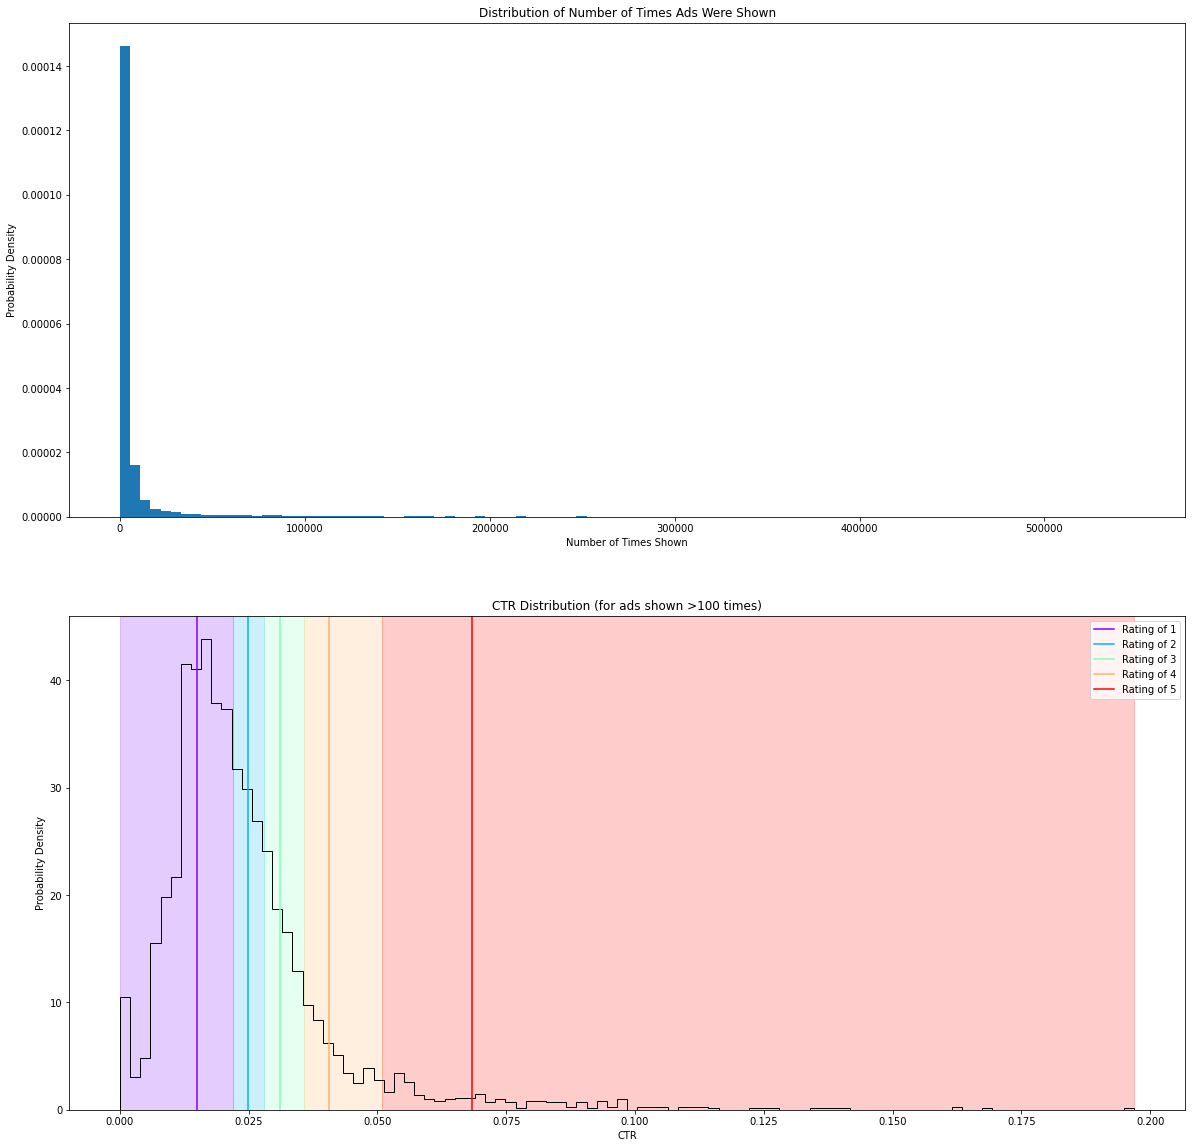

In [159]:
num_plots = 2
fig, axs = plt.subplots(num_plots, figsize=(20,10*num_plots))
num_times_shown_cutoff = 100

i = 0

axs[i].set_title("Distribution of Number of Times Ads Were Shown")
axs[i].set_xlabel("Number of Times Shown")
axs[i].set_ylabel("Probability Density")
axs[i].hist(num_times_shown, bins=100, density=True)
i += 1

data = ctrs[num_times_shown > num_times_shown_cutoff]

ratings, weights = np.unique(real_ratings, return_counts=True)
perm = np.argsort(ratings)
ratings = ratings[perm]
weights = weights[perm]
weights = weights/np.sum(weights)
print(weights)
percentiles = np.cumsum(np.insert(weights, 0, 0)) * 100

center_percentiles = (percentiles[1:] + percentiles[:-1]) / 2.

equivalents = np.percentile(data, percentiles)
center_equivalents = np.percentile(data, center_percentiles)

axs[i].set_title(f"CTR Distribution (for ads shown >{num_times_shown_cutoff} times)")
axs[i].set_xlabel("CTR")
axs[i].set_ylabel("Probability Density")
axs[i].hist(data, bins=100, density=True, color="black", histtype="step")
color = iter(cm.rainbow(np.linspace(0, 1, len(ratings))))
for j, q in enumerate(equivalents[:-1]):
    c = next(color)
    axs[i].axvspan(q, equivalents[j+1], color=c, alpha=0.2)
    axs[i].axvline(center_equivalents[j], label=f"Rating of {ratings[j]}", color=c)
axs[i].legend()
i += 1

results_df = pd.DataFrame({
    "Rating": ratings,
    "Lower Bound": equivalents[:-1],
    "Upper Bound": equivalents[1:],
    "Central Value": center_equivalents
})

results_df